In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pylab as plt

## Import and clean data

In [2]:
kawasaki_raw = pd.read_csv('data/Kawasaki Data v04.05.2017.csv', 
                           parse_dates=['dob', 'date_admission', 'date_discharge'], 
                           index_col=0)
kawasaki_raw.head()

,mrn,patient_initials,sex,dob,age_days,age_months,age_years,race,race_specify,ethnicity,...,echo2_criteria_level,ectasia_aneurysm3,lad_rad3,echo3_criteria_level,echopositive,kdlevel,kdclass,age_group,black,kd
study_id,,,,,,,,,,,,,,,,,,,,,
KD001,23640436,SA,0,2004-12-06,2221,72,6,0,NaN,1,...,0,0,0,0,1,5,2,3,0,1
KD003,30914774,OB,1,2009-01-09,354,11,0,4,NaN,1,...,1,1,0,0,1,1,1,2,0,1
KD004a,21827407,JB,1,2003-05-08,532,17,1,3,NaN,1,...,0,0,0,0,1,1,1,2,1,1
KD005,16903700,AB,1,1997-09-10,2371,77,6,4,NaN,2,...,0,0,0,0,1,1,1,3,0,1
KD006,25177965,GB,1,2005-01-20,413,13,1,4,NaN,2,...,0,0,0,0,0,1,1,2,0,1


In [3]:
assert kawasaki_raw.index.is_unique

In [4]:
race_lookup = {0: "American Indian/Alaska Native",   
1: "Asian",     
2: "Native Hawaiian or Other Paci c Islander",    
3: "Black or African American",    
4: "White",    
5: "More Than One Race",    
6: "Unknown / Not Reported",    
7: "Declined",   
8: "Hispanic",      
9: "Other"}

In [5]:
kawasaki_raw.assign(Race=kawasaki_raw.race.replace(race_lookup)).groupby('Race').size()

Race
American Indian/Alaska Native      2
Asian                             20
Black or African American        109
More Than One Race                 3
Other                             17
White                            299
dtype: int64

In [6]:
kawasaki_raw.therapy_responder.value_counts()

1    372
0     78
Name: therapy_responder, dtype: int64

In [7]:
kawasaki_raw.assign(Race=kawasaki_raw.race.replace(race_lookup)).groupby('Race').therapy_responder.mean().round(2)

Race
American Indian/Alaska Native    1.00
Asian                            0.90
Black or African American        0.75
More Than One Race               1.00
Other                            0.94
White                            0.84
Name: therapy_responder, dtype: float64

Calculate age from admission year and birth year

In [8]:
kawasaki_raw['age_months'] = (kawasaki_raw.date_admission - kawasaki_raw.dob).dt.days/30.
kawasaki_raw['age_months'].head()

study_id
KD001     74.033333
KD003     11.800000
KD004a    17.733333
KD005     79.033333
KD006     13.766667
Name: age_months, dtype: float64

In [9]:
kawasaki_raw['age_years'] = (kawasaki_raw.age_months/12.).astype(int)

In [10]:
kawasaki_raw['age_norm'] = ((kawasaki_raw.age_months - kawasaki_raw.age_months.mean())
                            /kawasaki_raw.age_months.std())

In [11]:
kawasaki_raw['age_norm2'] = kawasaki_raw['age_norm']**2

In [12]:
kawasaki_raw['other_race'] = (~kawasaki_raw.race.isin([3,4])).astype(int)

Potential covariates: hemoglobin, albumin, platelets, esr, crp, white count, alt, days of fever/days of illness, ast, sodium

In [13]:
relevant_cols = ['therapy_responder', 'sex', 'age_norm', 'age_norm2', 'age_years',
                 'black', 'other_race', 'ethnicity', 'completekd', 'hgb', 'albumin', 
                 'esr_mm_hr', 'plts', 'crp_mg_l', 'wbc', 'ast', 'illness_day_at_rx']

In [14]:
kawasaki_subset = (kawasaki_raw.loc[kawasaki_raw.kdclass!=3, relevant_cols]
                           .rename(columns={'sex':'male'})
                           .assign(non_responder=(kawasaki_raw.therapy_responder==0).astype(int)))
kawasaki_subset.head()

,therapy_responder,male,age_norm,age_norm2,age_years,black,other_race,ethnicity,completekd,hgb,albumin,esr_mm_hr,plts,crp_mg_l,wbc,ast,illness_day_at_rx,non_responder
study_id,,,,,,,,,,,,,,,,,,
KD001,1,0,0.960899,0.923326,6,0,1,1,0,11.4,3.0,NaN,209.0,24.000000,3.700000,68.0,6,0
KD003,0,1,-0.958262,0.918267,0,0,0,1,1,7.7,2.1,98.0,188.0,241.100010,7.300000,29.0,6,1
KD004a,0,1,-0.775289,0.601074,1,1,0,1,1,11.1,NaN,22.0,332.0,NaN,19.500000,NaN,3,1
KD005,1,1,1.115089,1.243424,6,0,0,2,1,14.1,3.3,65.0,281.0,192.000000,22.799999,43.0,8,0
KD006,1,1,-0.897614,0.805711,1,0,0,2,1,10.0,3.5,62.0,507.0,48.099998,27.000000,31.0,9,0


In [15]:
kawasaki_subset.shape

(393, 18)

In [16]:
kawasaki_subset.groupby('black').therapy_responder.mean()

black
0    0.838926
1    0.726316
Name: therapy_responder, dtype: float64

Probability of responder does not seem to vary with age. Wide variation at the end is mostly a sample size artefact.

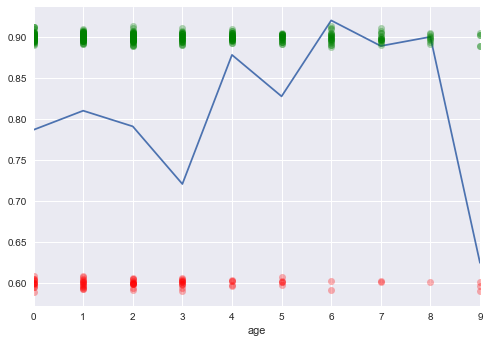

In [17]:
ax = (kawasaki_subset[kawasaki_subset.age_years<10]
              .assign(age_int=kawasaki_subset.age_years.astype(int))
              .groupby('age_int')).therapy_responder.mean().plot()
ax.set_xlabel('age')
responders = kawasaki_subset[kawasaki_subset.therapy_responder==1]
ax.plot(responders.age_years, np.random.normal(0.9, 0.005, size=len(responders)), 
        'go', alpha=0.3)

nonresponders = kawasaki_subset[kawasaki_subset.therapy_responder==0]
ax.plot(nonresponders.age_years, np.random.normal(0.6, 0.005, size=len(nonresponders)), 
        'ro', alpha=0.3)

In [18]:
kawasaki_subset.isnull().mean().round(2)

therapy_responder    0.00
male                 0.00
age_norm             0.00
age_norm2            0.00
age_years            0.00
black                0.00
other_race           0.00
ethnicity            0.00
completekd           0.00
hgb                  0.07
albumin              0.42
esr_mm_hr            0.11
plts                 0.06
crp_mg_l             0.23
wbc                  0.06
ast                  0.21
illness_day_at_rx    0.00
non_responder        0.00
dtype: float64

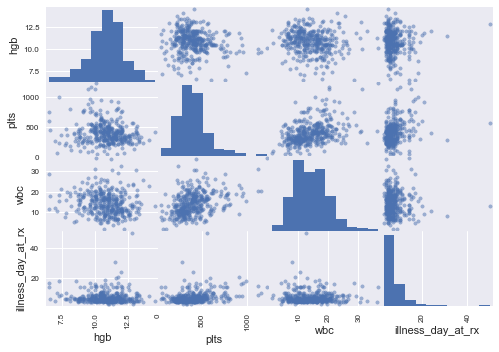

In [25]:
pd.scatter_matrix(kawasaki_subset[['hgb', 'plts', 'wbc', 'illness_day_at_rx']]);

## Model specification

In [26]:
def interpolate(x0,y0, x):
    x = np.array(x)

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d=dl+dr
    wl = dr/d

    return wl*y0[idx-1] + (1-wl)*y0[idx]


In [159]:
import theano.tensor as tt
GaussianRandomWalk = pm.distributions.timeseries.GaussianRandomWalk

covs = ['male', 'black', 'completekd']
k = len(covs)
nknots = 7

knots = np.linspace(kawasaki_subset.age_norm.min(), kawasaki_subset.age_norm.max(), nknots)

with pm.Model() as model:
    
    # Baseline probability of non-response
    θ = pm.Normal('θ', 0, sd=10)
    # Coefficients for covariates
    β = pm.Normal('β', 0, sd=10, shape=k)
    
    odds = pm.Deterministic('odds', tt.exp(β))
    
    # Age effect (non-linear)
    σ = pm.HalfCauchy('σ', 2.5)
    y = GaussianRandomWalk('y', sd=σ, shape=nknots)

    α = pm.Deterministic('α', interpolate(knots, y, kawasaki_subset.age_norm))
    
    
    # Probabilities
    p_race_female = pm.Deterministic('p_race_female', pm.invlogit(θ))
    p_race_male = pm.Deterministic('p_race_male', pm.invlogit(θ + β[1]))
    p_race_black_female = pm.Deterministic('p_race_black_female', 
                                           pm.invlogit(θ + β[1]))
    p_race_black_male = pm.Deterministic('p_race_black_male', 
                                         pm.invlogit(θ + β[0] + β[1]))
        
    π = pm.Deterministic('π', pm.invlogit(θ + tt.dot(kawasaki_subset[covs].values, β)+ α*kawasaki_subset.age_norm.values))
    
    non_responder = pm.Bernoulli('non_responder', π, observed=kawasaki_subset.non_responder)
    
    brier = pm.Deterministic('brier_score', tt.mean((π - kawasaki_subset.non_responder)**2))

In [160]:
with model:
    trace = pm.sample(2000, njobs=2, n_init=50000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -205.87: 100%|██████████| 50000/50000 [00:08<00:00, 5648.54it/s]
Finished [100%]: Average ELBO = -205.73
100%|██████████| 2000/2000 [00:17<00:00, 114.30it/s]


In [161]:
def energy_plot(trace):
    energy = trace['energy']
    energy_diff = np.diff(energy)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.hist(energy - energy.mean(), bins=30,
            lw=0, alpha=0.5,
            label="Energy")
    ax.hist(energy_diff, bins=30,
            lw=0, alpha=0.5,
            label="Energy difference")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.legend()

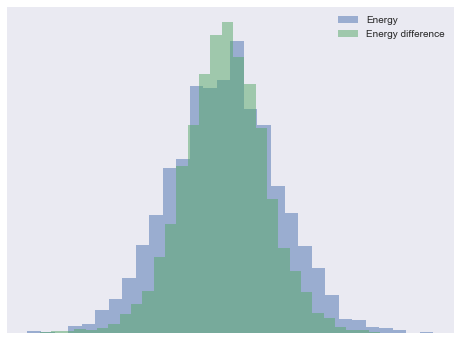

In [162]:
energy_plot(trace)

Odds ratios for responder. Tabulated values below plot.

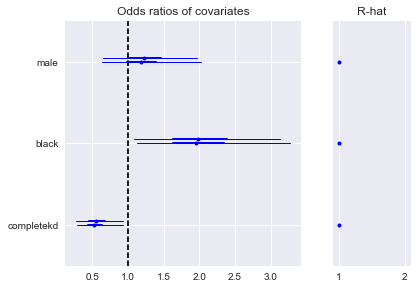

In [163]:
pm.forestplot(trace[1000:], varnames=['odds'], ylabels=covs, vline=1, 
              main='Odds ratios of covariates')

Age effect

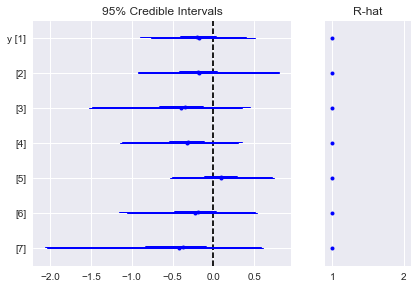

In [164]:
pm.forestplot(trace[burn:], varnames=['y'])

In [165]:
pm.summary(trace[burn:], varnames=['odds'])


odds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.242            0.362            0.011            [0.643, 1.996]
  2.041            0.567            0.012            [1.079, 3.218]
  0.568            0.179            0.007            [0.274, 0.932]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.678          0.991          1.193          1.425          2.116
  1.155          1.630          1.963          2.375          3.316
  0.307          0.441          0.535          0.661          0.998



array([<matplotlib.axes._subplots.AxesSubplot object at 0x13158ff98>], dtype=object)

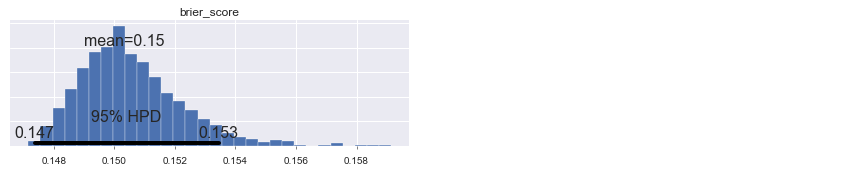

In [166]:
pm.plot_posterior(trace[burn:], varnames=['brier_score'])

In [168]:
probs = trace['π']
probs.shape

(4000, 393)

In [169]:
predictions = pd.DataFrame({'p': probs.mean(0),
                            'obs': kawasaki_subset.non_responder})

In [170]:
predictions.sort_values(by='p', ascending=False).head()

,obs,p
study_id,,
KD047,0,0.439560
KD237,0,0.437816
kd455,0,0.434570
KD082a,1,0.431633
KD327,0,0.427658
KD063a,0,0.425703
KD054,0,0.422814
KD032,0,0.401774
kd474,0,0.376369


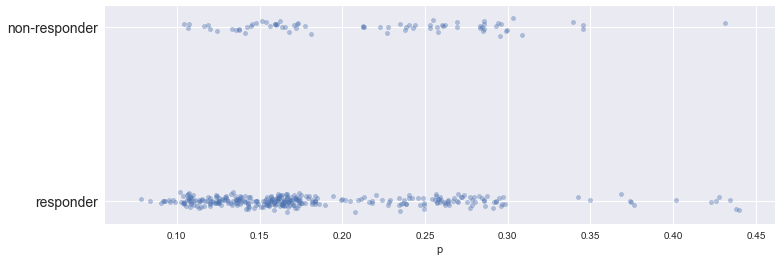

In [183]:
ax = (predictions.assign(obsj=predictions.obs+0.02*np.random.randn(len(predictions)))
              .plot.scatter(x='p', y='obsj', alpha=0.4, figsize=(12,4)))
ax.set_yticks([0,1])
ax.set_yticklabels(['responder', 'non-responder'], fontsize=14)
ax.set_ylabel('')

In [74]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresh = roc_curve(predictions.obs, predictions.p)
roc_auc = auc(fpr, tpr)

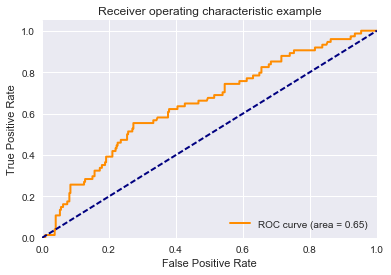

In [178]:
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

### Expanded covariate model

In [80]:
import theano.tensor as tt
GaussianRandomWalk = pm.distributions.timeseries.GaussianRandomWalk

binary_covs = ['male', 'black', 'completekd']
k = len(binary_covs) + 4
nknots = 7

knots = np.linspace(kawasaki_subset.age_norm.min(), kawasaki_subset.age_norm.max(), nknots)

lasso = False

with pm.Model() as covariate_model:
    
    # Imputation of missing values
    hgb_norm = (kawasaki_subset.hgb - kawasaki_subset.hgb.mean()) / (2*kawasaki_subset.hgb.std())
    hgb_imp = pm.Normal('hgb_imp', 0, sd=0.5, observed=hgb_norm)
    
    plts_norm = (kawasaki_subset.plts - kawasaki_subset.plts.mean()) / (2*kawasaki_subset.plts.std())
    plts_imp = pm.Normal('plts_imp', 0, sd=0.5, observed=plts_norm)
    
    wbc_norm = (kawasaki_subset.wbc - kawasaki_subset.wbc.mean()) / (2*kawasaki_subset.wbc.std())
    wbc_imp = pm.Normal('wbc_imp', 0, sd=0.5, observed=wbc_centered)
    
    illness_day_norm = ((kawasaki_subset.illness_day_at_rx - kawasaki_subset.illness_day_at_rx.mean()) 
                                / (2*kawasaki_subset.illness_day_at_rx.std()))
    
    # Baseline probability of non-response
    θ = pm.Normal('θ', 0, sd=10)
    
    if lasso:
        # Lasso parameters
        lam = pm.Exponential('s', 0.1)
        tau = pm.Uniform('tau', 0, 1000)
        b = lam * tau

        # Coefficients for covariates
        β = pm.Laplace('β', 0, b, shape=k)
    else:
        β = pm.Normal('β', 0, sd=10, shape=k)
    
    odds = pm.Deterministic('odds', tt.exp(β))
        
    π = pm.Deterministic('π', pm.invlogit(θ + tt.dot(kawasaki_subset[binary_covs].values, β[:-4])
                                       + β[-4]*illness_day_norm + β[-3]*hgb_imp + β[-2]*plts_imp + β[-1]*wbc_imp))
    
    non_responder = pm.Bernoulli('non_responder', π, observed=kawasaki_subset.non_responder)
    
    brier = pm.Deterministic('brier_score', tt.mean((π - kawasaki_subset.non_responder)**2))

In [81]:
with covariate_model:
    cov_trace = pm.sample(5000, tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
  0%|          | 0/200000 [00:00<?, ?it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -25,518

100%|██████████| 5000/5000 [02:29<00:00, 33.44it/s]


In [69]:
pm.summary(cov_trace[-1000:], varnames=['odds'])


odds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.143            0.239            0.008            [0.735, 1.615]
  1.440            0.453            0.018            [0.806, 2.352]
  0.789            0.196            0.007            [0.402, 1.102]
  1.080            0.205            0.006            [0.747, 1.564]
  0.782            0.185            0.007            [0.425, 1.087]
  0.913            0.183            0.006            [0.528, 1.224]
  1.053            0.026            0.001            [1.001, 1.104]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.801          0.991          1.087          1.252          1.716
  0.895          1.096          1.322          1.681          2.525
  0.408          0.649          0.799          0.944          1.143
  0.751    

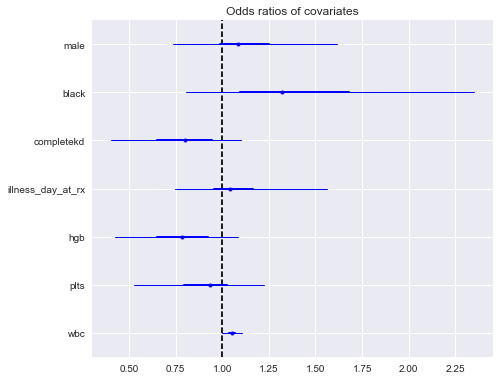

In [70]:
pm.forestplot(cov_trace[-1000:], varnames=['odds'], ylabels=covs + ['hgb', 'plts', 'wbc'], vline=1, 
              main='Odds ratios of covariates')

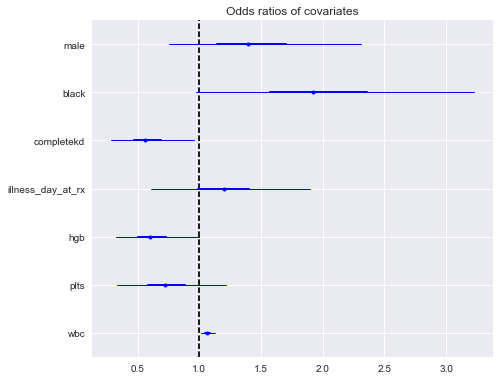

In [86]:
pm.forestplot(cov_trace[-1000:], varnames=['odds'], ylabels=covs + ['hgb', 'plts', 'wbc'], vline=1, 
              main='Odds ratios of covariates')

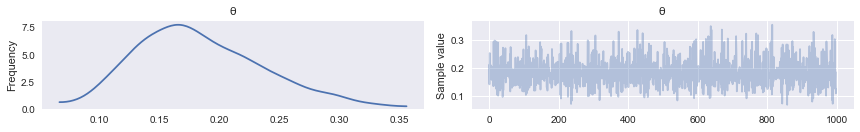

In [82]:
pm.traceplot(cov_trace[-1000:], varnames=['θ'], transform=lambda x: 1/(1+np.exp(-x)));

In [ ]:
pm.traceplot(cov_trace[-1000:], varnames=['brier'])

In [83]:
probs = cov_trace['π']
predictions = pd.DataFrame({'p': probs.mean(0),
                            'obs': kawasaki_subset.non_responder})

In [84]:
fpr, tpr, thresh = roc_curve(predictions.obs, predictions.p)
roc_auc = auc(fpr, tpr)

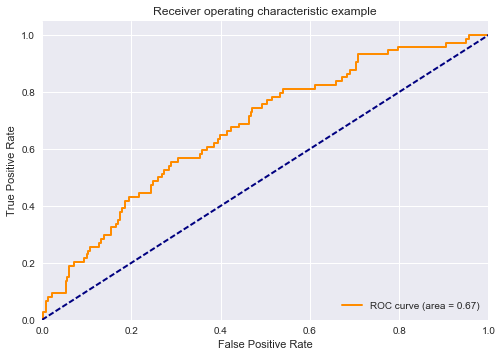

In [85]:
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")